# Negative Binomial Regression (Students absence example)

## Negative binomial distribution review

The negative binomial distribution is flexible with multiple possible formulations. For example, it can model the number of *trials* or *failures* in a sequence of independent Bernoulli trials with probability of success (or failure) $p$ until the $k$-th "success". If we want to model the number of trials until the $k$-th success, the probability mass function (pmf) results:

$$
p(y | k, p)= \binom{y - 1}{y-k}(1 -p)^{y - k}p^k
$$

where $0 \le p \le 1$ is the probability of success in each Bernoulli trial, $k > 0$, usually integer, $y \in \{k, k + 1, \cdots\}$ and $Y$ is the number of trials until the $k$-th success.

In this case, since we are modeling the number of *trials* until the $k$-th success, $y$ starts at $k$ and can be any integer greater than or equal to $k$. If instead we want to model the number of *failures* until the $k$-th success, we can use the same definition but $Y$ represents failures and starts at $0$ and there's a slightly different pmf:

$$
p(y | k, p)= \binom{y + k - 1}{k-1}(1 -p)^{y}p^k
$$

In this case, $y$ starts at $0$ and can be any integer greater than or equal to $0$. When modeling failures, $y$ starts at 0, when modeling trials, $y$ starts at $k$.

These are not the only ways of defining the negative binomial distribution, there are plenty of options! One of the most interesting, and the one you see in [PyMC](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.NegativeBinomial.html), the library we use in Bambi for the backend, is as a continuous mixture. The negative binomial distribution describes a Poisson random variable whose rate is also a random variable (not a fixed constant!) following a gamma distribution. Or in other words, conditional on a gamma-distributed variable $\mu$, the variable $Y$ has a Poisson distribution with mean $\mu$.

Under this alternative definition, the pmf is

$$
\displaystyle p(y | k, \alpha) = \binom{y + \alpha - 1}{y} \left(\frac{\alpha}{\mu + \alpha}\right)^\alpha\left(\frac{\mu}{\mu + \alpha}\right)^y
$$

where $\mu$ is the parameter of the Poisson distribution (the mean, and variance too!) and $\alpha$ is the rate parameter of the gamma.

In [1]:
import warnings

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import nbinom

az.style.use("arviz-darkgrid")

warnings.simplefilter(action='ignore', category=FutureWarning)

SciPy uses the number of *failures* until $k$ successes definition, therefore $y$ starts at 0. In the following plot, we have  the probability of observing $y$ failures before we see $k=3$ successes. 

In [2]:
y = np.arange(0, 30)
k = 3
p1 = 0.5
p2 = 0.3

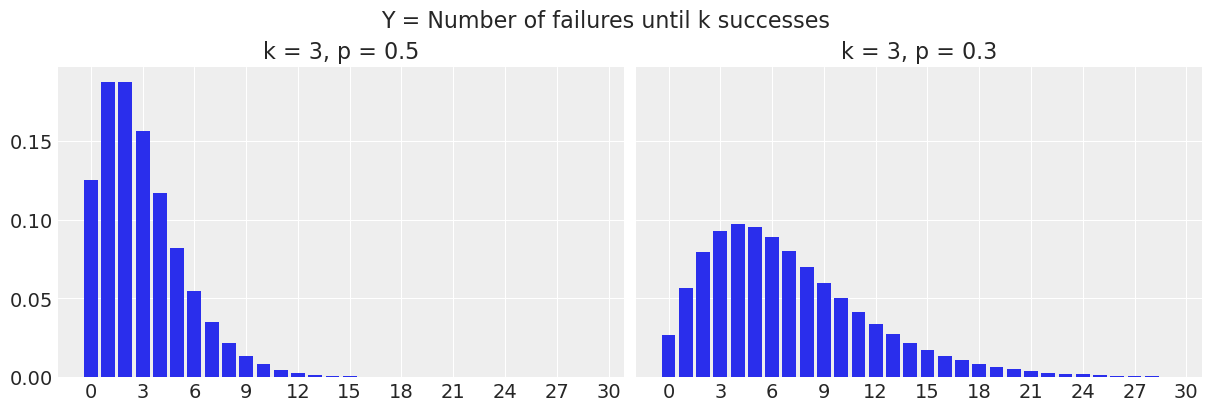

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax[0].bar(y, nbinom.pmf(y, k, p1))
ax[0].set_xticks(np.linspace(0, 30, num=11))
ax[0].set_title(f"k = {k}, p = {p1}")

ax[1].bar(y, nbinom.pmf(y, k, p2))
ax[1].set_xticks(np.linspace(0, 30, num=11))
ax[1].set_title(f"k = {k}, p = {p2}")

fig.suptitle("Y = Number of failures until k successes", fontsize=16);

For example, when $p=0.5$, the probability of seeing $y=0$ failures before 3 successes (or in other words, the probability of having 3 successes out of 3 trials) is 0.125, and the probability of seeing $y=3$ failures before 3 successes is 0.156.

In [4]:
print(nbinom.pmf(y, k, p1)[0])
print(nbinom.pmf(y, k, p1)[3])

0.125
0.15625


To change the definition to the number of *trials* until $k$ successes, we just need to shift the whole thing to the right by adding $k$ to the $y$ values.

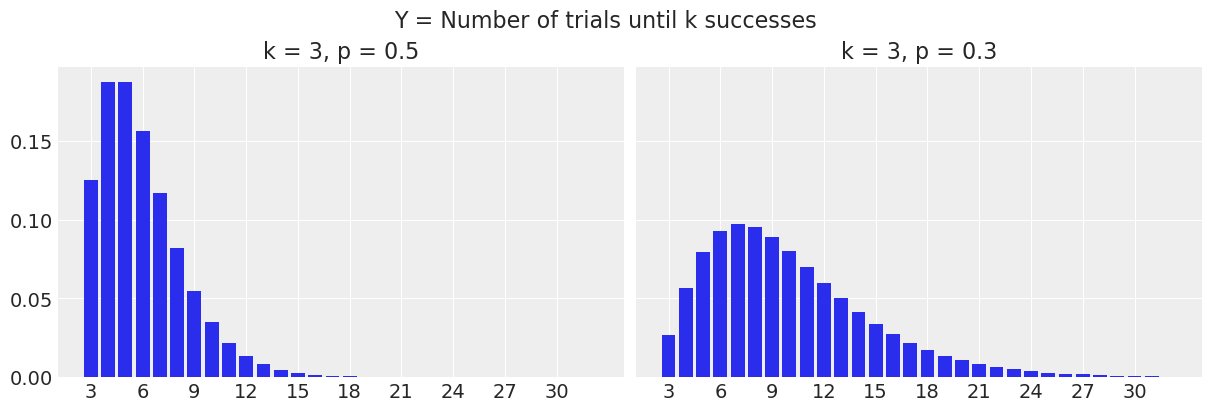

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax[0].bar(y + k, nbinom.pmf(y, k, p1))
ax[0].set_xticks(np.linspace(3, 30, num=10))
ax[0].set_title(f"k = {k}, p = {p1}")

ax[1].bar(y + k, nbinom.pmf(y, k, p2))
ax[1].set_xticks(np.linspace(3, 30, num=10))
ax[1].set_title(f"k = {k}, p = {p2}")

fig.suptitle("Y = Number of trials until k successes", fontsize=16);

## Negative binomial in GLM

The negative binomial distribution belongs to the exponential family, and the canonical link function is 

$$
g(\mu_i) = \log\left(\frac{\mu_i}{k + \mu_i}\right) = \log\left(\frac{k}{\mu_i} + 1\right)
$$

but it is difficult to interpret. The log link is usually preferred because of the analogy with Poisson model, and it also tends to give better results.

## Load and explore Students data

This example is based on this [UCLA example](https://stats.idre.ucla.edu/r/dae/negative-binomial-regression/).

School administrators study the attendance behavior of high school juniors at two schools.  Predictors of the **number of days of absence** include the **type of program** in which the student is enrolled and a **standardized test in math**. We have attendance data on 314 high school juniors.

The variables of interest in the dataset are

* daysabs: The number of days of absence. It is our response variable.
* progr: The type of program. Can be one of 'General', 'Academic', or 'Vocational'.
* math: Score in a standardized math test.

In [6]:
data = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta")

In [7]:
data.head()

,id,gender,math,daysabs,prog
0,1001.0,male,63.0,4.0,2.0
1,1002.0,male,27.0,4.0,2.0
2,1003.0,female,20.0,2.0,2.0
3,1004.0,female,16.0,3.0,2.0
4,1005.0,female,2.0,3.0,2.0


We assign categories to the values 1, 2, and 3 of our `"prog"` variable.

In [8]:
data["prog"] = data["prog"].map({1: "General", 2: "Academic", 3: "Vocational"})
data.head()

,id,gender,math,daysabs,prog
0,1001.0,male,63.0,4.0,Academic
1,1002.0,male,27.0,4.0,Academic
2,1003.0,female,20.0,2.0,Academic
3,1004.0,female,16.0,3.0,Academic
4,1005.0,female,2.0,3.0,Academic


The Academic program is the most popular program (167/314) and General is the least popular one (40/314)

In [9]:
data["prog"].value_counts()

prog
Academic      167
Vocational    107
General        40
Name: count, dtype: int64

Let's explore the distributions of math score and days of absence for each of the three programs listed above. The vertical lines indicate the mean values.

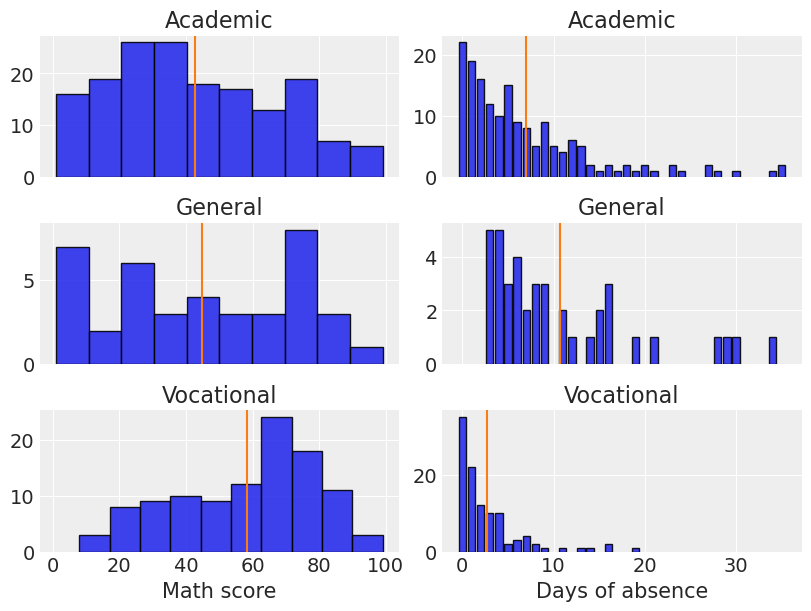

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(8, 6), sharex="col")
programs = list(data["prog"].unique())
programs.sort()

for idx, program in enumerate(programs):
    # Histogram
    ax[idx, 0].hist(data[data["prog"] == program]["math"], edgecolor='black', alpha=0.9)
    ax[idx, 0].axvline(data[data["prog"] == program]["math"].mean(), color="C1")

    # Barplot
    days = data[data["prog"] == program]["daysabs"]
    days_mean = days.mean()
    days_counts = days.value_counts()
    values = list(days_counts.index)
    count = days_counts.values
    ax[idx, 1].bar(values, count, edgecolor='black', alpha=0.9)
    ax[idx, 1].axvline(days_mean, color="C1")

    # Titles
    ax[idx, 0].set_title(program)
    ax[idx, 1].set_title(program)

plt.setp(ax[-1, 0], xlabel="Math score")
plt.setp(ax[-1, 1], xlabel="Days of absence");

The first impression we have is that the distribution of math scores is not equal for any of the programs. It looks right-skewed for students under the Academic program, left-skewed for students under the Vocational program, and roughly uniform for students in the General program (although there's a drop in the highest values). Clearly those in the Vocational program has the highest mean for the math score.
 
On the other hand, the distribution of the days of absence is right-skewed in all cases. Students in the General program present the highest absence mean while the Vocational group is the one who misses fewer classes on average.

## Models

We are interested in measuring the association between the type of the program and the math score with the days of absence. It's also of interest to see if the association between math score and days of absence is different in each type of program. 

In order to answer our questions, we are going to fit and compare two models. The first model uses the type of the program and the math score as predictors. The second model also includes the interaction between these two variables. The score in the math test is going to be standardized in both cases to make things easier for the sampler and save some seconds. A good idea to follow along is to run these models without scaling `math` and comparing how long it took to fit.

We are going to use a negative binomial likelihood to model the days of absence. But let's stop here and think why we use this likelihood. Earlier, we said that the negative binomial distributon arises when our variable represents the number of trials until we got $k$ successes. However, the number of trials is fixed, i.e. the number of school days in a given year is not a random variable. So if we stick to the definition, we could think of the two alternative views for this problem

* Each of the $n$ days is a trial, and we record whether the student is absent ($y=1$) or not ($y=0$). This corresponds to a binary regression setting, where we could think of logistic regression or something alike. A problem here is that we have the sum of $y$ for a student, but not the $n$.
* The whole school year represents the space where events occur and we count how many absences we see in that space for each student. This gives us a Poisson regression setting (count of an event in a given space or time).

We also know that when $n$ is large and $p$ is small, the Binomial distribution can be approximated with a Poisson distribution with $\lambda = n * p$. We don't know exactly $n$ in this scenario, but we know it is around 180, and we do know that $p$ is small because you can't skip classes all the time. So both modeling approaches should give similar results.

But then, why negative binomial? Can't we just use a Poisson likelihood?

Yes, we can. However, using a Poisson likelihood implies that the mean is equal to the variance, and that is usually an unrealistic assumption. If it turns out the variance is either substantially smaller or greater than the mean, the Poisson regression model results in a poor fit. Alternatively, if we use a negative binomial likelihood, the variance is not forced to be equal to the mean, and there's more flexibility to handle a given dataset, and consequently, the fit tends to be better.

### Model 1 

$$
\log(\mathbb{E}[Y_i]) = \beta_1 \text{Academic}_i + \beta_2 \text{General}_i + \beta_3 \text{Vocational}_i + \beta_4 \text{Math\_std}_i
$$

### Model 2

$$
\begin{aligned}
\log(\mathbb{E}[Y_i]) &= \beta_1 \text{Academic}_i + \beta_2 \text{General}_i + \beta_3 \text{Vocational}_i + \beta_4 \text{Math\_std}_i + \\
            & \beta_5 \text{General}_i \cdot \text{Math\_std}_i + \beta_6 \text{Vocational}_i \cdot \text{Math\_std}_i
\end{aligned}
$$

In both cases we have the following dummy variables


$$\text{Academic}_i = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if student is under Academic program} \\
        0 & \textrm{other case} 
    \end{array}
\right.
$$

$$\text{General}_i = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if student is under General program} \\
        0 & \textrm{other case} 
    \end{array}
\right.
$$

$$\text{Vocational}_i = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if student is under Vocational program} \\
        0 & \textrm{other case} 
    \end{array}
\right.
$$

and $Y$ represents the days of absence.

So, for example, the first model for a student under the Vocational program reduces to
$$
\log(\mathbb{E}[Y_i]) = \beta_3 + \beta_4 \text{Math\_std}_i
$$

And one last thing to note is we've decided not to include an intercept term, that's why you don't see any $\beta_0$ above. This choice allows us to represent the effect of each program directly with $\beta_1$, $\beta_2$, and $\beta_3$.

## Model fit

It's very easy to fit these models with Bambi. We just pass a formula describing the terms in the model and Bambi will know how to handle each of them correctly. The `0` on the right hand side of `~` simply means we don't want to have the intercept term that is added by default. `scale(math)` tells Bambi we want to use standardize `math` before being included in the model. By default, Bambi uses a log link for negative binomial GLMs. We'll stick to this default here.

### Model 1

In [11]:
model_additive = bmb.Model("daysabs ~ 0 + prog + scale(math)", data, family="negativebinomial")
idata_additive = model_additive.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, prog, scale(math)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Model 2

For this second model we just add `prog:scale(math)` to indicate the interaction. A shorthand would be to use `y ~ 0 + prog*scale(math)`, which uses the **full interaction** operator. In other words, it just means we want to include the interaction between `prog` and `scale(math)` as well as their main effects.

In [12]:
model_interaction = bmb.Model("daysabs ~ 0 + prog + scale(math) + prog:scale(math)", data, family="negativebinomial")
idata_interaction = model_interaction.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, prog, scale(math), prog:scale(math)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


## Explore models

The first thing we do is calling `az.summary()`. Here we pass the `InferenceData` object the `.fit()` returned. This prints information about the marginal posteriors for each parameter in the model as well as convergence diagnostics.

In [13]:
az.summary(idata_additive)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.019,0.107,0.815,1.211,0.001,0.002,5436.0,3179.0,1.0
prog[Academic],1.887,0.084,1.729,2.039,0.001,0.001,5609.0,3101.0,1.0
prog[General],2.339,0.168,2.024,2.657,0.002,0.003,5321.0,3082.0,1.0
prog[Vocational],1.048,0.119,0.821,1.268,0.002,0.002,5767.0,3354.0,1.0
scale(math),-0.152,0.064,-0.272,-0.036,0.001,0.001,4684.0,3089.0,1.0


In [14]:
az.summary(idata_interaction)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.019,0.105,0.821,1.216,0.002,0.002,4638.0,3138.0,1.0
prog[Academic],1.878,0.085,1.734,2.053,0.001,0.001,4370.0,3159.0,1.0
prog[General],2.345,0.169,2.042,2.674,0.003,0.002,4513.0,3050.0,1.0
prog[Vocational],0.987,0.129,0.743,1.226,0.002,0.002,4563.0,3109.0,1.0
scale(math),-0.193,0.081,-0.346,-0.039,0.001,0.001,3920.0,3165.0,1.0
prog:scale(math)[General],0.018,0.170,-0.296,0.334,0.003,0.002,4414.0,3343.0,1.0
prog:scale(math)[Vocational],0.192,0.161,-0.103,0.492,0.003,0.003,4017.0,3101.0,1.0


The information in the two tables above can be visualized in a more concise manner using a forest plot. ArviZ provides us with `plot_forest()`. There we simply pass a list containing the `InferenceData` objects of the models we want to compare.

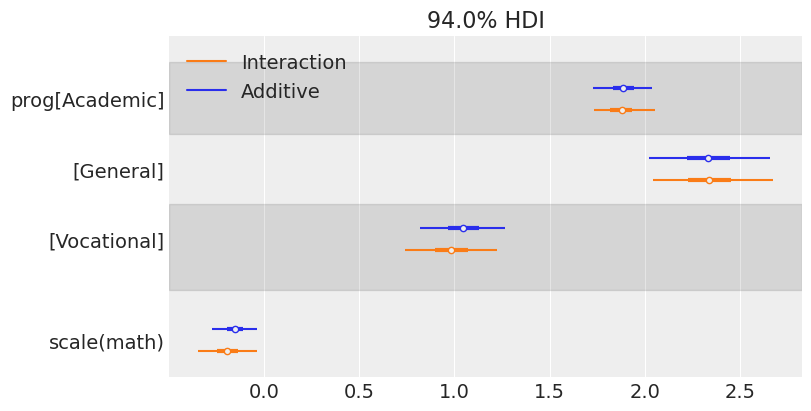

In [15]:
az.plot_forest(
    [idata_additive, idata_interaction],
    model_names=["Additive", "Interaction"],
    var_names=["prog", "scale(math)"],
    combined=True,
    figsize=(8, 4)
);

One of the first things one can note when seeing this plot is the similarity between the marginal posteriors. Maybe one can conclude that the variability of the marginal posterior of `scale(math)` is slightly lower in the model that considers the interaction, but the difference is not significant. 

We can also make conclusions about the association between the program and the math score with the days of absence. First, we see the posterior for the Vocational group is to the left of the posterior for the two other programs, meaning it is associated with fewer absences (as we have seen when first exploring our data). There also seems to be a difference between General and Academic, where we may conclude the students in the General group tend to miss more classes.

In addition, the marginal posterior for `math` shows negative values in both cases. This means that students with higher math scores tend to miss fewer classes. Below, we see a forest plot with the posteriors for the coefficients of the interaction effects. Both of them overlap with 0, which means the data does not give much evidence to support there is an interaction effect between program and math score (i.e., the association between math and days of absence is similar for all the programs).

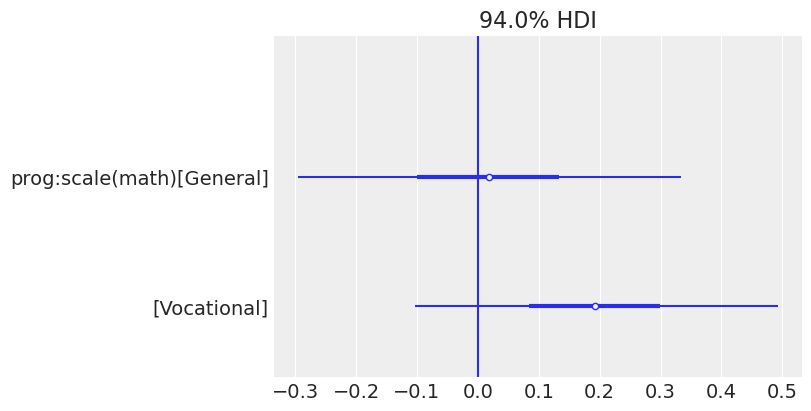

In [16]:
az.plot_forest(idata_interaction, var_names=["prog:scale(math)"], combined=True, figsize=(8, 4))
plt.axvline(0);

## Plot predicted mean response

We finish this example showing how we can get predictions for new data and plot the mean response for each program together with credible intervals.

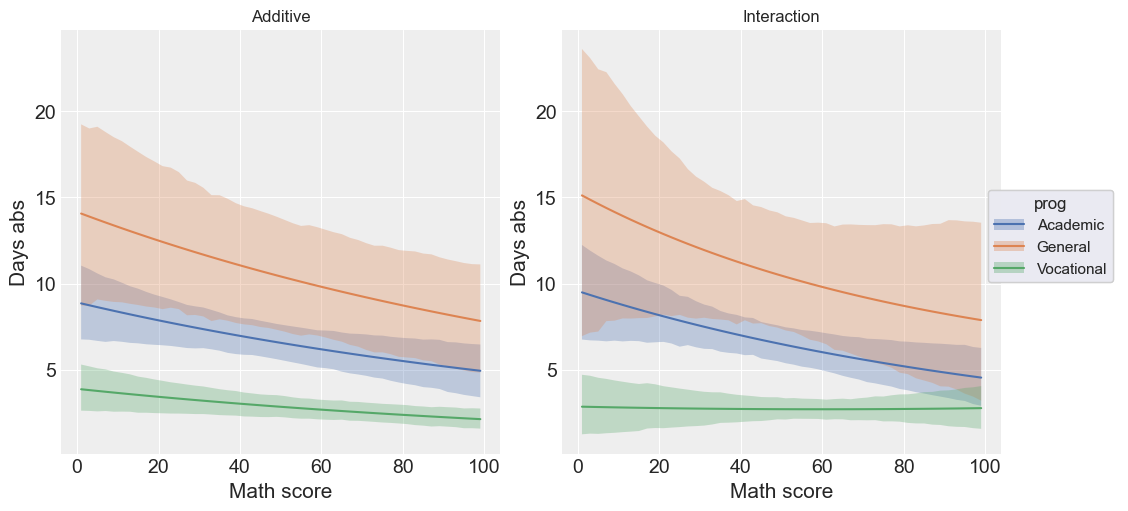

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

p1 = bmb.interpret.plot_predictions(
    model_additive,
    idata_additive,
    conditional=["math", "prog"],
    subplot_kwargs={"main": "math", "group": "prog"},
    fig_kwargs={"xlabel": "Math score", "ylabel": "Days abs", "title": "Additive"}
)

p2 = bmb.interpret.plot_predictions(
    model_interaction,
    idata_interaction,
    conditional=["math", "prog"],
    subplot_kwargs={"main": "math", "group": "prog"},
    fig_kwargs={"xlabel": "Math score", "ylabel": "Days abs", "title": "Interaction"}
)

p1.on(axes[0]).plot()
p2.on(axes[1]).plot().show()

As we can see in this plot, the interval for the mean response for the Vocational program does not overlap with the interval for the other two groups, representing the group of students who miss fewer classes. On the right panel we can also see that including interaction terms does not change the slopes significantly because the posterior distributions of these coefficients have a substantial overlap with 0.

If you've made it to the end of this notebook and you're still curious about what else you can do with these two models, you're invited to use `az.compare()` to compare the fit of the two models. What do you expect before seeing the plot? Why? Is there anything else you could do to improve the fit of the model?

Also, if you're still curious about what this model would have looked like with the Poisson likelihood, you just need to replace `family="negativebinomial"` with `family="poisson"` and then you're ready to compare results!

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue, 17 Feb 2026

Python implementation: CPython
Python version       : 3.13.12
IPython version      : 9.10.0

arviz     : 0.23.4
bambi     : 0.1.dev890+g3e105f2cc.d20260217
matplotlib: 3.10.8
numpy     : 2.3.5
pandas    : 2.3.3

Watermark: 2.6.0

